In [1]:
import numpy as np
import glob
import re

from aicsimageio import AICSImage, readers
from pathlib import Path
from matplotlib import pyplot as plt

from blimp.preprocessing.illumination_correction import IlluminationCorrection

03-Jul-24 15:46:03 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


# Correct illumination

Search images of the correct channel in the input directories

In [2]:
images_dir_1 = Path("/srv/scratch/berrylab/z3532965/operetta_cls/ARMC5_TransInhib/230821_ARMC5_TransInhib/230821_ARMC5_TransInhib_TotalRNAPol__2023-08-25T14_29_20-Measurement 1/OME-TIFF-MIP/")
image_files_1 = glob.glob(str(images_dir_1 / "*.tiff"))

images_dir_2 = Path("/srv/scratch/berrylab/z3532965/operetta_cls/ARMC5_TransInhib/231110_ARMC5_TransInhib/231110_ARMC5_TransInhib__2023-11-14T18_12_24-Measurement 1/OME-TIFF-MIP/")
image_files_2 = glob.glob(str(images_dir_2 / "*.tiff"))

images_dir_3 = Path("/srv/scratch/berrylab/z3532965/operetta_cls/ARMC5_TransInhib/240322_ARMC5_TransInhib/240322_ARMC5_TransInhib__2024-03-26T13_50_23-Measurement 1/OME-TIFF-MIP/")
image_files_3 = glob.glob(str(images_dir_3 / "*.tiff"))

Bright dust in images can be detrimental for calculation of a standard deviation for illumination correction. We check that all images are within the same intensity range

In [3]:
def find_outlier_indices(image_files):
    n_channels = AICSImage(image_files[0],reader=readers.ome_tiff_reader.OmeTiffReader).dims.C
    image_std = np.stack(
        [[np.std(a=AICSImage(image_file,reader=readers.ome_tiff_reader.OmeTiffReader).get_image_data('YX',C=c)) for c in range(n_channels)] for image_file in image_files]
    )
    image_std_p25 = np.percentile(image_std,25,axis=0)
    image_std_p75 = np.percentile(image_std,75,axis=0)
    image_std_iqr = image_std_p75 - image_std_p25
    upper_limit = image_std_p75 + 1.5*image_std_iqr
    outlier = image_std > upper_limit
    outlier_indices = np.argwhere(outlier[:,0:2])[:,0]
    return outlier_indices, image_std

In [ ]:
%%time
outlier_indices_1, image_std_1 = find_outlier_indices(image_files_1)
reference_image_files_1 = np.delete(image_files_1,outlier_indices_1).tolist()

In [ ]:
%%time
outlier_indices_2, image_std_2 = find_outlier_indices(image_files_2)
reference_image_files_2 = np.delete(image_files_2,outlier_indices_2).tolist()

In [ ]:
%%time
outlier_indices_3, image_std_3 = find_outlier_indices(image_files_3)
reference_image_files_3 = np.delete(image_files_3,outlier_indices_3).tolist()

Fit ``blimp.IlluminationCorrection`` objects

In [ ]:
illumination_correction_1 = IlluminationCorrection(
    reference_images=reference_image_files_1,
    timelapse=False,
)
illumination_correction_1.plot()

In [ ]:
illumination_correction_2 = IlluminationCorrection(
    reference_images=reference_image_files_2,
    timelapse=False,
)
illumination_correction_2.plot()

In [ ]:
illumination_correction_3 = IlluminationCorrection(
    reference_images=reference_image_files_3,
    timelapse=False,
)
illumination_correction_3.plot()

# Save illumination correction objects to disk

The ``blimp.IlluminationCorrection`` object can be persisted on disk to be later applied when analysing images

In [ ]:
illumcorr_1_filename = Path(images_dir_1).parent / "ILLUMCORR" / "illumination_correction.pkl"
illumcorr_2_filename = Path(images_dir_2).parent / "ILLUMCORR" / "illumination_correction.pkl"
illumcorr_3_filename = Path(images_dir_3).parent / "ILLUMCORR" / "illumination_correction.pkl"

In [ ]:
illumination_correction_1.save(Path(illumcorr_1_filename))
illumination_correction_2.save(Path(illumcorr_2_filename))
illumination_correction_3.save(Path(illumcorr_3_filename))

# Check results

IlluminationCorrection can be applied using the ``correct()`` method of the ``blimp.IlluminationCorrection`` object

In [21]:
illumination_correction_1 = IlluminationCorrection(from_file=illumcorr_1_filename)
illumination_correction_2 = IlluminationCorrection(from_file=illumcorr_2_filename)
illumination_correction_3 = IlluminationCorrection(from_file=illumcorr_3_filename)

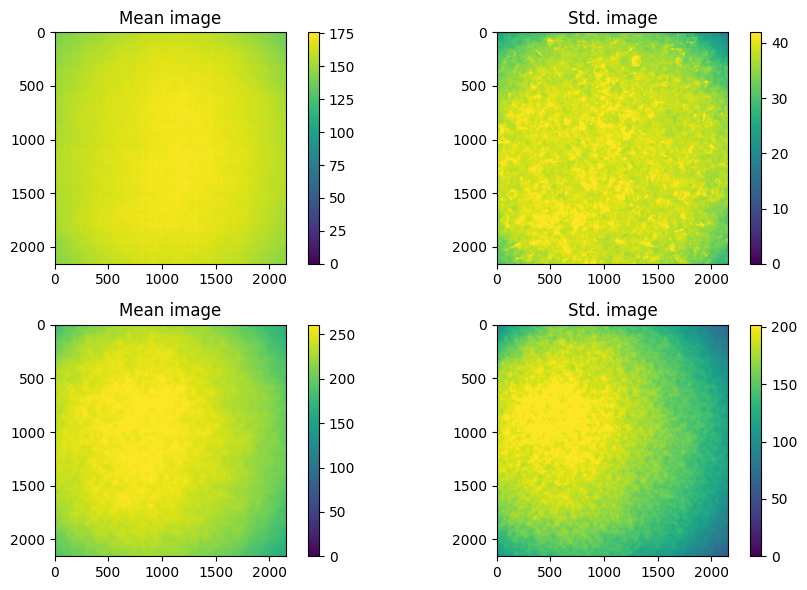

In [22]:
illumination_correction_1.plot()

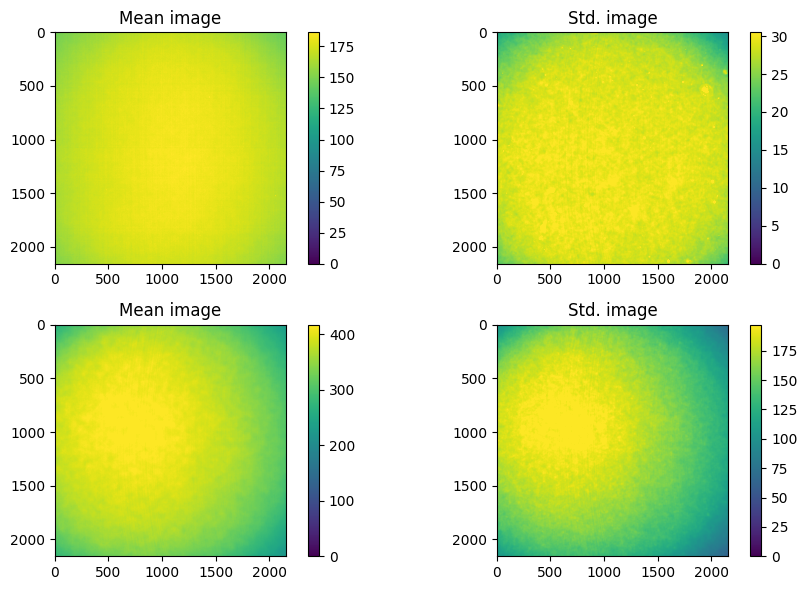

In [23]:
illumination_correction_2.plot()

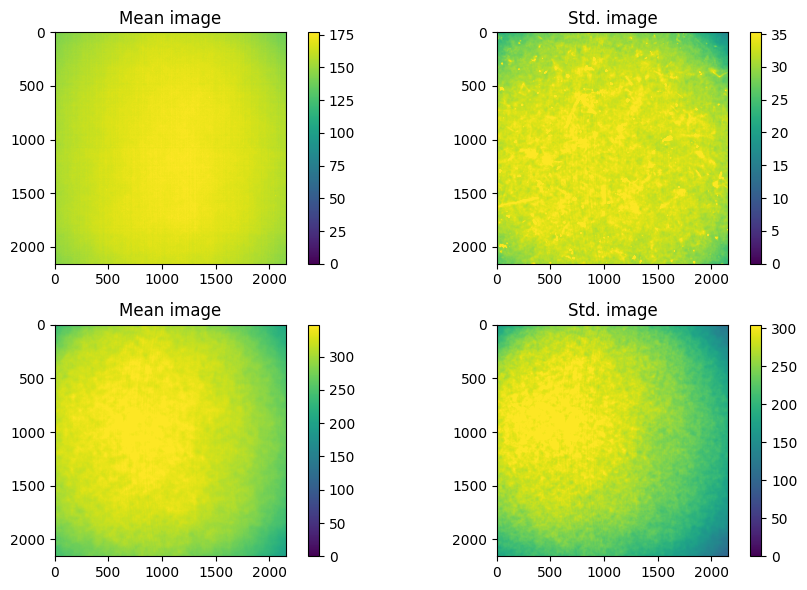

In [24]:
illumination_correction_3.plot()

In [25]:
raw = AICSImage(image_files_1[102], reader=readers.ome_tiff_reader.OmeTiffReader)
corrected = illumination_correction_1.correct(raw)

In [26]:
#illumination_correction.mean_image.get_image_data("YX", C=1, Z=0, T=0)
illumination_correction_1.mean_mean_image

[163.67828356883442, 234.08313910816656]

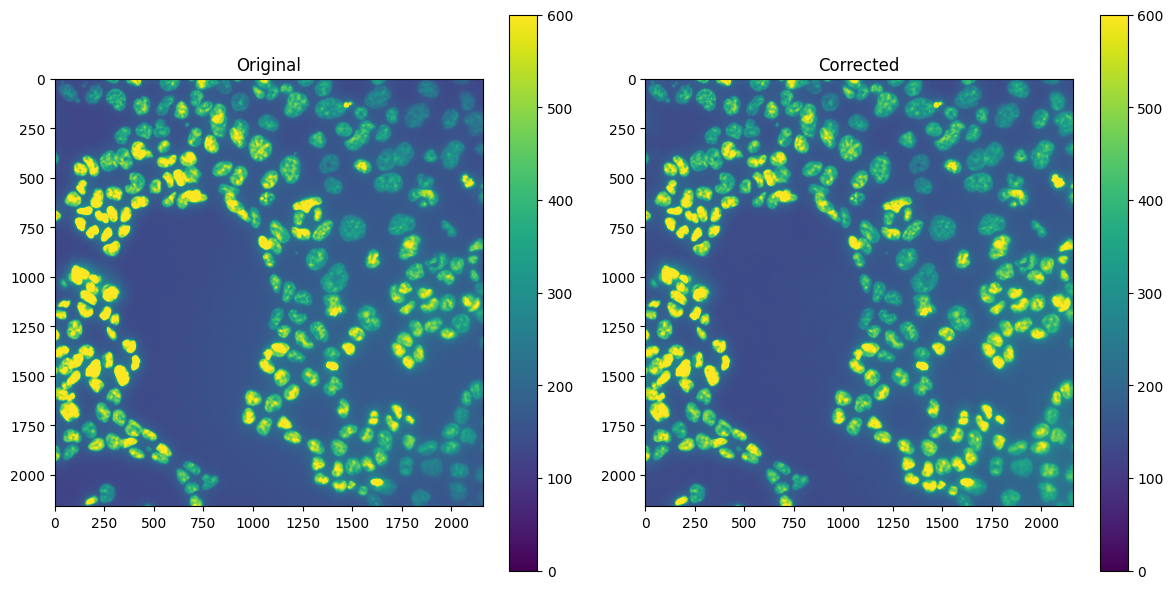

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im = axes[0].imshow(raw.get_image_data('YX',C=1,T=0), vmin=0, vmax=600)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(corrected.get_image_data('YX',C=1,T=0), vmin=0, vmax=600)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

In [30]:
corrected.channel_names

['Alexa 568', 'DAPI']